# Loading data & Time conversion

In [8]:
# load activity data
import pandas as pd

def read_act_df(base_dir, time_cols=['Started', 'Finished', 'Updated']):
    act_df = pd.read_csv(base_dir)
    act_df = act_df.dropna(subset=time_cols)

    for col in time_cols:
        act_df[col] = pd.to_datetime(act_df[col], format='%Y/%m/%d %H:%M')
        if act_df[col].isna().any():
            raise ValueError(f"Column '{col}' contains NaN or unparseable datetime values.")
        act_df[col] = act_df[col].dt.tz_localize('UTC+09:00')

    return act_df

act_path = '../data/TrainingDataPD25/TrainActivities.csv'
act_df = read_act_df(act_path)
display(act_df.head(10))
print(act_df['Activity Type'].value_counts().index)

,ID,Activity Type ID,Activity Type,Started,Finished,Updated,Subject
0,1130251,2806,1 (FACING camera) Sit and stand,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,U22
1,1130254,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,U22
2,1130257,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,U22
3,1130261,2806,1 (FACING camera) Sit and stand,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,U22
4,1130292,2806,1 (FACING camera) Sit and stand,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,U2
5,1130293,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,U2
6,1130294,2808,3 Stand up from chair - both hands with SHAKING,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,U2
7,1130306,2806,1 (FACING camera) Sit and stand,2024-09-02 06:44:00+09:00,2024-09-02 06:44:00+09:00,2024-09-02 06:44:00+09:00,U1
8,1136872,2806,1 (FACING camera) Sit and stand,2024-09-03 19:56:00+09:00,2024-09-03 19:56:00+09:00,2024-09-03 19:56:00+09:00,U22
9,1136878,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-03 19:56:00+09:00,2024-09-03 19:57:00+09:00,2024-09-03 19:57:00+09:00,U22


Index(['1 (FACING camera) Sit and stand',
       '2 (FACING camera) both hands SHAKING (sitting position)',
       '3 Stand up from chair - both hands with SHAKING',
       '5 (Sideway) both hands SHAKING (sitting)',
       '6 (Sideway) STAND up with - both hands SHAKING',
       '10 Slow walk (SHAKING hands/body, tiny step, head forward)',
       '4 (Sideway) Sit & stand', '8 Walk (LEFT --> Right --> Left)',
       '9 Walk & STOP/frozen, full body shaking, rotate then return back',
       '7 Cool down - sitting/relax'],
      dtype='object', name='Activity Type')


In [9]:
# Load acceleration data
# load all csv files into a DataFrame
import os
import glob

base_dir = '/Users/tptn/MachineLearning/tremor_challenge2/data/TrainingDataPD25/users_timeXYZ/users'
headers = ['id', 'datetime', 'x', 'y', 'z']

def read_users_df(base_dir, headers):
    """ Read all csv files in users folder 
    Return:
        users_df: a DataFrame contains all csv files
    Args:
        base_dir: base folder to csv files
        headers: headers for csv files
    """
    df_list = [] # to store all csv files
    for id in os.listdir(base_dir):
        path = os.path.join(base_dir, id)

        if os.path.isdir(path):
            files = glob.glob(os.path.join(path, '*.csv'))

            for f in files:
                df = pd.read_csv(f, header=None, names=headers) # load csv
                df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M:%S.%f%z') # conver to datetime
                tz = df['datetime'].dt.tz # get the timezone
                if tz != 'UTC+09:00':
                    df['datetime'] = df['datetime'].dt.tz_convert('UTC+09:00')
                df_list.append(df)
    users_df = pd.concat(df_list, ignore_index=True)
    users_df.sort_values(by=['datetime'], inplace=True)
    return users_df

users_df = read_users_df(base_dir, headers)

# Prepare the data for feature extraction

In [76]:
def preprocess_acceleration_df(users_df):
    """
    Remove duplicates replace with mean values of them

    Parameters
    ----------
    users_df : DataFrame
    """
    processed_df = users_df.groupby('datetime', as_index=False)[['x', 'y', 'z']].mean().reset_index(drop=True)
    return processed_df

def add_duration(df):
    """Adding duration between two given cols
    
    Return:
        DataFrame

    Args:
        df (DataFrame)
    """
    assert ValueError(df['Started'] - df['Finished'] ==  pd.Timedelta(minutes=1) - pd.Timedelta(microseconds=1))
    df_cp = df.copy()
    df_cp['Started'] = df_cp['Started'].dt.floor('s')
    df_cp['Finished'] = df_cp['Finished'].dt.floor('s') + pd.Timedelta(minutes=1) - pd.Timedelta(microseconds=1)
    return df_cp

def preprocess_activity_label_df(act_df, is_test_set=False):
    """
    For both training and testing set, add row id for mapping predicted labels to original data.

    For training set:
    1. Remove duplicates based on 'Started', 'Finished', 'Activity Type', 'Subject'
    and keep the most lastest 'Update' time
    2. Add duration between 'Started' and 'Finished'
    3. Sort by 'Started' in ascending order
    
    For test set:
    1. Remove na rows
    2. Add duration between 'Started' and 'Finished'
    3. Sort by 'Started' in ascending order
    
    Parameters
    ----------
    act_df : DataFrame
    
    Returns
    -------
    processed_df : DataFrame
    """
    act_df['Row ID'] = act_df['ID'] # add row id for mapping predicted labels to original data
    #1
    if not is_test_set: # if not test set, drop duplicates
        columns = ['Started', 'Finished', 'Activity Type', 'Subject']
        drop_df = act_df.sort_values(by=['Updated'], ascending=False).drop_duplicates(subset=columns, keep='first').reset_index(drop=True)
    else: # if is test set, drop na rows
        drop_df = act_df.dropna(subset=['Started', 'Finished']).reset_index(drop=True)
    #2
    add_dur_df = add_duration(drop_df)
    #3
    sorted_df = add_dur_df.sort_values(by='Started', ascending=True).reset_index(drop=True)
    
    processed_df = sorted_df.copy() 
    return processed_df

### Dummy code to test

In [11]:
### check duplicates ###
# duplicates = users_df[users_df['datetime'].duplicated(keep=False)]
# duplicates.head(10)
# users_df actually has duplicates?????
# let calculate avg and drop duplicates
# averaged_df = users_df.groupby('datetime', as_index=False)[['x', 'y', 'z']].mean()
# print(act_df['Updated'].max())
# dups = act_df[act_df['Updated'] == act_df['Updated'].max()]
# duplicates = act_df[act_df.duplicated(
#     subset=['Started', 'Finished', 'Activity Type', 'Subject'], 
#     keep=False)].sort_values(
#         by=['Updated'], 
#         ascending=False)
# display(duplicates.head(10))
# display(dups.head(10))
# display(act_df.sort_values(
#     by=['Updated'],
#     ascending=False).head(10))
# There is multiple activities have the same Started, Finished, Activity Type, Subject but different Updated
# So we drop duplicates but keep the lastest Updated
# sorted_act_df = act_df.sort_values(by='Updated', ascending=False)
# drop_dups_act_df = sorted_act_df.drop_duplicates(
#     subset=['Started', 'Finished', 'Activity Type', 'Subject'], 
#     keep='first').reset_index(drop=True)
# drop_dups_act_df.head(10)
# drop_dups_act_df.shape
### check na ###
# users_df.isna().sum()
# act_df.isna().sum()
# there is no na at all
# def add_duration(df):
#     """Adding interval between two given cols
    
#     Return:
#         DataFrame: a dataframe with added interval between two columns

#     Args:
#         df (DataFrame): original dataframe
#     """
#     df_cp = df.copy()

#     df_cp['Started'] = df_cp['Started'].dt.floor('s')
#     df_cp['Finished'] = df_cp['Finished'].dt.floor('s') + pd.Timedelta(minutes=1) - pd.Timedelta(microseconds=1)

#     return df_cp

# dur_df = add_duration(act_df)
# display(dur_df[['Started', 'Finished']].head(10))
# display(act_df[['Started', 'Finished']].head(10))

# Segmentation

In [72]:
def seg_acceleration_df_per_activity(users_df, act_df, seg_test_set=False):
    """
    Segmenting the dataset into one dataframe per activity.

    Each activity will has its own dataframe, which contains all the timestamps and accelerometer data within the activity time range.

    Returns
    -------
    seg_list: list of df 
        one df contains acceleration data of corresponding activity label
    seg_id_list: list of row id
        this id is used to map the predicted labels back to the original activity label data
    seg_label_list: list of label
        one label correspond to one df in seg_list

    Parameters
    -----------
    users_df: DataFrame
        Acceleration data
    act_df:  DataFrame
        Activity label data
    """

    seg_list = []
    seg_label_list = []
    seg_id_list= [] # to map predicts back to activity label data

    for i in range(0, len(act_df)):
        started_at = act_df.iloc[i]['Started']
        finished_at = act_df.iloc[i]['Finished']

        seg = users_df[(users_df['datetime'] >= started_at) & (users_df['datetime'] <= finished_at)]
        seg_id = act_df.iloc[i]['Row ID']

        if not seg_test_set:
            seg_label = act_df.iloc[i]['Activity Type ID']

        # check if seq is not empty
        if len(seg) != 0:
            seg_list.append(seg)
            seg_id_list.append(seg_id)
            if not seg_test_set:
                seg_label_list.append(seg_label)

    return seg_list, seg_id_list, seg_label_list

In [78]:
processed_users_df = preprocess_acceleration_df(users_df)
processed_act_df = preprocess_activity_label_df(act_df)
seg_list, seg_id_list, seg_label_list = seg_acceleration_df_per_activity(processed_users_df, processed_act_df, seg_test_set=False)

In [ ]:
print(f'seg_list {len(seg_list)}')
print(f'seg_id_list {len(seg_id_list)}')
print(f'seg_label_list {len(seg_label_list)}')

seg_list 199
seg_id_list 199
seg_label_list 199


[np.int64(1130292),
 np.int64(1130293),
 np.int64(1130294),
 np.int64(1130306),
 np.int64(1136872),
 np.int64(1136878),
 np.int64(1136882),
 np.int64(1136887),
 np.int64(1136889),
 np.int64(1136890),
 np.int64(1136896),
 np.int64(1136898),
 np.int64(1136903),
 np.int64(1136904),
 np.int64(1136908),
 np.int64(1136906),
 np.int64(1136910),
 np.int64(1136913),
 np.int64(1136911),
 np.int64(1136916),
 np.int64(1136917),
 np.int64(1136918),
 np.int64(1136927),
 np.int64(1136936),
 np.int64(1136945),
 np.int64(1136950),
 np.int64(1136976),
 np.int64(1136981),
 np.int64(1136983),
 np.int64(1136986),
 np.int64(1136987),
 np.int64(1136991),
 np.int64(1136992),
 np.int64(1136994),
 np.int64(1137001),
 np.int64(1137002),
 np.int64(1137003),
 np.int64(1137010),
 np.int64(1137023),
 np.int64(1137025),
 np.int64(1137026),
 np.int64(1137027),
 np.int64(1137038),
 np.int64(1137039),
 np.int64(1137053),
 np.int64(1137055),
 np.int64(1137058),
 np.int64(1137061),
 np.int64(1137059),
 np.int64(1137062),


# Feature extraction


In [ ]:
%pip install scipy numpy statsmodels

In [15]:
import numpy as np
from scipy.stats import iqr, skew, kurtosis
from scipy.signal import periodogram

def zero_crossing_rate(signal):
    return ((signal[:-1] * signal[1:]) < 0).sum() / len(signal)

def safe_corr(a, b):
    if len(a) < 2 or np.std(a) == 0 or np.std(b) == 0:
        return 0.0
    return np.corrcoef(a, b)[0, 1]

def band_energy(signal, fs=50, low=4, high=6):
    """Compute energy in a frequency band (e.g., 4–6 Hz for tremor)."""
    f, Pxx = periodogram(signal, fs=fs)
    return np.sum(Pxx[(f >= low) & (f <= high)])

def get_feats(df, columns=['x', 'y', 'z'], fs=50):
    """Method to extract features from acceleration dataframe.
    Returns
    -------
    feats: list of numpy values
        List of features extracted from the acceleration data.
    """
    feats = []
    tremor_band_energies = []

    for col in columns:
        data = df[col].values

        std_ = np.std(data, ddof=0)
        mean_ = np.mean(data)
        max_ = np.max(data)
        min_ = np.min(data)
        median_ = np.median(data)
        iqr_ = iqr(data)
        var_ = np.var(data)
        skew_ = skew(data)
        kurt_ = kurtosis(data)
        ptp_ = np.ptp(data)
        rms_ = np.sqrt(np.mean(data**2))
        zcr_ = zero_crossing_rate(data)

        feats.extend([
            std_, mean_, max_, min_, median_, iqr_,
            var_, skew_, kurt_, ptp_, rms_, zcr_
        ])

        # Tremor-specific feature (4–6 Hz band energy)
        tremor_energy = band_energy(data, fs=fs, low=4, high=6)
        tremor_band_energies.append(tremor_energy)

    # Signal Magnitude Area (SMA)
    mag = np.abs(df[columns]).sum(axis=1)
    sma = mag.sum() / len(df)
    feats.append(sma)

    # Axis correlations
    feats.extend([
        safe_corr(df['x'], df['y']),
        safe_corr(df['y'], df['z']),
        safe_corr(df['z'], df['x']),
    ])

    # Append tremor band energy per axis and total
    feats.extend(tremor_band_energies)  # x, y, z band energy
    feats.append(sum(tremor_band_energies))  # total tremor energy

    return feats

# Window overlapping & Segmentation

In [84]:
def window_segment(df, wsize, stride):
    """Segment using sliding window method

    Returns:
        List: list of features per activity
    Args:
        df: accelerometer data
        wsize: window size [seconds]
        stride: how much the window slide
    """
    features_list = []
    start_time = df['datetime'].min()
    end_time = df['datetime'].max()
    current_start = start_time

    while current_start + pd.Timedelta(seconds=wsize) <= end_time:
        current_end = current_start + pd.Timedelta(seconds=wsize)
        window = df[(df['datetime'] >= current_start) & (df['datetime'] < current_end)]
        if not window.empty:
            feats = get_feats(window)
            features_list.append(feats)
        current_start += pd.Timedelta(seconds=stride)

    return features_list

def segment_all(seg_list, seg_id_list, seg_label_list, wsize=1, stride=0.5, seg_test_set=False):
    all_features = []
    all_ids = []
    all_labels = []

    if not seg_test_set: # if not is test set, we have labels
        for df, id, label in zip(seg_list, seg_id_list, seg_label_list):
            feats_list = window_segment(df, wsize, stride)

            all_features.extend(feats_list)
            all_ids.extend([id] * len(feats_list))
            all_labels.extend([label] * len(feats_list))

    if seg_test_set: # if is test set, we don't have labels, no window segmentation
        for df, id in zip(seg_list, seg_id_list):
            feats = get_feats(df)
            all_features.append(feats)
            all_ids.extend([id] * len(feats))

    # Define feature names for columns (must match get_feats output)
    axes = ['x', 'y', 'z']
    base_features = ['std', 'mean', 'max', 'min', 'median', 'iqr', 'var', 'skew', 'kurt', 'ptp', 'rms', 'zcr']
    tremor_band = ['tremor_energy']

    columns = []
    for axis in axes:
        for feat in base_features + tremor_band:
            columns.append(f'{feat}_{axis}')

    columns += ['sma', 'corr_xy', 'corr_yz', 'corr_zx', 'total_tremor_energy']

    features_df = pd.DataFrame(all_features, columns=columns)
    if not seg_test_set:
        features_df['label'] = all_labels

    return features_df

In [ ]:
WINDOW_SIZE = 1  # seconds
OVERLAP_RATE = 0.5 * WINDOW_SIZE  # seconds
all_features_and_labels_df = segment_all(seg_list, seg_label_list, wsize=WINDOW_SIZE, stride=WINDOW_SIZE-OVERLAP_RATE)

# Save & Load the segments

In [ ]:
# save the processed data frame for the sake of my mentality
file_name = f'all_feats_and_labels_wsize_{WINDOW_SIZE}_overlap_{OVERLAP_RATE}.csv'
all_features_and_labels_df.to_csv(f'../data/{file_name}', index=False)

In [22]:
# load the saved data frame
all_df = pd.read_csv('../data/all_feats_and_labels_wsize_1_overlap_0.5.csv')
all_df = all_df.dropna()  # Drop rows with NaN values
# print(f'before save: {all_features_and_labels_df.shape}, after load: {all_df.shape}')

# Correlation matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_corr(df, drop_cols=['label', 'subject']):
    # Drop label for correlation
    corr_matrix = df.drop(columns=drop_cols).corr()

    # Plot correlation heatmap
    plt.figure(figsize=(16, 12))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f")
    plt.title("Feature Correlation Heatmap (excluding label)")
    plt.tight_layout()
    plt.show()

In [ ]:
plot_corr(all_df)

# Split the data

In [23]:
def split_by_position(X, y, start_ratio=0.0, train_ratio=0.7):
    """
    Split dataset into train/test without shuffling.
    
    Parameters:
    - X, y: features and labels
    - start_ratio: float in [0, 1), where to start the 70% slice
    - train_ratio: proportion of the data to use as training (e.g. 0.7)

    Returns:
    - X_train, X_test, y_train, y_test
    """
    assert 0 <= start_ratio < 1, "start_ratio must be in [0, 1)"
    assert 0 < train_ratio <= 1, "train_ratio must be in (0, 1]"

    total_len = len(X)
    start_index = int(start_ratio * total_len)
    end_index = start_index + int(train_ratio * total_len)

    # Handle edge case where end_index exceeds total_len
    if end_index > total_len:
        end_index = total_len

    X_train = X[start_index:end_index]
    y_train = y[start_index:end_index]

    # Use everything else for test
    X_test = np.concatenate((X[:start_index], X[end_index:]), axis=0)
    y_test = np.concatenate((y[:start_index], y[end_index:]), axis=0)

    return X_train, X_test, y_train, y_test

In [24]:
X = all_df.drop(columns=['label', 'subject']).values
y = all_df['label'].values

In [ ]:
# don't use this split, it gives bad performance
# X_train, X_test, y_train, y_test = split_by_position(X, y, start_ratio=0.05, train_ratio=0.7)
# print(f'X_train_shape: {X_train.shape}, X_test_shape: {X_test.shape}')
# print(f'y_train_shape: {y_train.shape}, y_test_shape: {y_test.shape}')
# print(f'y_train_act_labels: {set(y_train.tolist())}\n y_test_act_labels: {set(y_test.tolist())}')

In [25]:
# split data into 70% training and 30% testing, while preserving the class distribution in the training set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)
print(f'X_train_shape: {X_train.shape}, X_test_shape: {X_test.shape}')
print(f'y_train_shape: {y_train.shape}, y_test_shape: {y_test.shape}')
print(f'y_train_act_labels: {set(y_train.tolist())}\n y_test_act_labels: {set(y_test.tolist())}')

X_train_shape: (22230, 44), X_test_shape: (9528, 44)
y_train_shape: (22230,), y_test_shape: (9528,)
y_train_act_labels: {2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815}
 y_test_act_labels: {2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815}


# Handle imbalanced classes

## ADASYN

In [ ]:
# from imblearn.over_sampling import ADASYN

# ada = ADASYN(random_state=42)

# X_resampled, y_resampled = ada.fit_resample(X_train, y_train)

# print(f'X: {X.shape}, y: {y.shape}')
# print(f'X_resampled: {X_resampled.shape}, y_resampled: {y_resampled.shape}')
#### NOTE: ADASYN does not work well with this dataset. ###

## SMOTE

In [ ]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)

# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# print(f'X: {X.shape}, y: {y.shape}')
# print(f'X_resampled: {X_resampled.shape}, y_resampled: {y_resampled.shape}')

## Random Over Sampler

In [ ]:
from imblearn.over_sampling import RandomOverSampler

randomSampler = RandomOverSampler(random_state=42)

X_resampled, y_resampled = randomSampler.fit_resample(X_train, y_train)

print(f'X: {X_train.shape}, y: {y_train.shape}')
print(f'X_resampled: {X_resampled.shape}, y_resampled: {y_resampled.shape}')

## Plot the distribution of the original and resampled data

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Count occurrences
counter_before = Counter(y_train)
counter_after = Counter(y_resampled)

# Get sorted class labels
classes = sorted(list(set(y_train)))
counts_before = [counter_before[cls] for cls in classes]
counts_after = [counter_after[cls] for cls in classes]

# Plotting
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, counts_before, width=width, label='Before Oversampling')
plt.bar(x + width/2, counts_after, width=width, label='After Oversampling')

plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution Before and After Oversampling')
plt.xticks(x, classes)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

NameError: name 'y_resampled' is not defined

# Predict good algorithm for this dataset

In [26]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test) # without resampling
# models, predictions = clf.fit(X_resampled, X_test, y_resampled, y_test) # with resampling

print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10887
[LightGBM] [Info] Number of data points in the train set: 22230, number of used features: 44
[LightGBM] [Info] Start training from score -2.600062
[LightGBM] [Info] Start training from score -2.190768
[LightGBM] [Info] Start training from score -2.332724
[LightGBM] [Info] Start training from score -2.455911
[LightGBM] [Info] Start training from score -2.371964
[LightGBM] [Info] Start training from score -2.125375
[LightGBM] [Info] Start training from score -3.105451
[LightGBM] [Info] Start training from score -2.647187
[LightGBM] [Info] Start training from score -1.900876
[LightGBM] [Info] Start training from score -1.875317
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                     

# Only Machine Learning, No Deep Learning

In [28]:
# for ploting confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def plot_confusion_matrix(y_predict):
    # compute confusion matrix
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_predict)
    # Plot with seaborn
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

## RandomForest

              precision    recall  f1-score   support

        2806       0.55      0.41      0.47       708
        2807       0.50      0.52      0.51      1066
        2808       0.44      0.37      0.40       925
        2809       0.30      0.31      0.30       817
        2810       0.48      0.47      0.48       888
        2811       0.51      0.60      0.55      1138
        2812       0.01      0.01      0.01       426
        2813       0.50      0.45      0.47       675
        2814       0.69      0.78      0.74      1424
        2815       0.77      0.79      0.78      1461

    accuracy                           0.54      9528
   macro avg       0.48      0.47      0.47      9528
weighted avg       0.53      0.54      0.53      9528



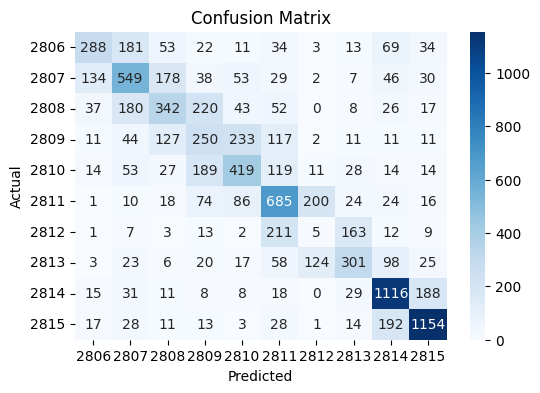

In [56]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1)
# rfc.fit(X_resampled, y_resampled)
rfc.fit(X_train, y_train)
from sklearn.metrics import classification_report
y_predict = rfc.predict(X_test)
print(classification_report(y_test, y_predict))
plot_confusion_matrix(y_predict)
### NOTE: without over sampling random forest performs better ###

## Save the model

In [59]:
# save random forest model
import joblib
import os

model_dir = "saved_models"
os.makedirs(model_dir, exist_ok=True) # base dir to save model

def save_model(model, model_name):
    """Save the model to a file."""
    joblib.dump(model, model_name)
    print(f"Model saved to {model_name}")


model_name = os.path.join(model_dir, f"random_forest_model_{pd.Timestamp.now().strftime('%Y%m%d_%H')}.joblib") # path to model name
save_model(rfc, model_name)

['saved_models/random_forest_model_20250527_15.joblib']

In [61]:
# load the model
rfc_saved_model = joblib.load('/Users/tptn/MachineLearning/tremor_challenge2/scripts/saved_models/random_forest_model_20250527_15.joblib')

## ExtraTreesClassifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
etc = ExtraTreesClassifier(n_estimators=500, n_jobs=-1)
etc.fit(X_resampled, y_resampled)
y_predict = etc.predict(X_test)
print(classification_report(y_test, y_predict))
plot_confusion_matrix(y_predict)
# ExtraTrees and RandomForest perform similarly

# Conclusion

In conclusion, the model performance does not change much: 
- While increasing the amount of features -> chosen features not effective.
- While decreasing the window size. However, there is STILL a slightly increase in performance .
On the other hand, the model performance change:
- While over sampling not applied, the model performance increased, and vice versa.

In comparison with other machine learning methods:
- Extra Trees and Random Forest have similarity in performance.
- While Label Spreading is not as good as the above algorithms.

# Predict on testing set

In [85]:
test_df = read_act_df('../data/TestingDataMay27/TestActivities-20240920.csv')
processed_test_df = preprocess_activity_label_df(test_df, is_test_set=True)
seg_list_test, seg_id_list_test, seg_label_list_test = seg_acceleration_df_per_activity(processed_users_df, processed_test_df, seg_test_set=True)
test_features_df = segment_all(seg_list_test, seg_id_list_test, seg_label_list_test, seg_test_set=True)

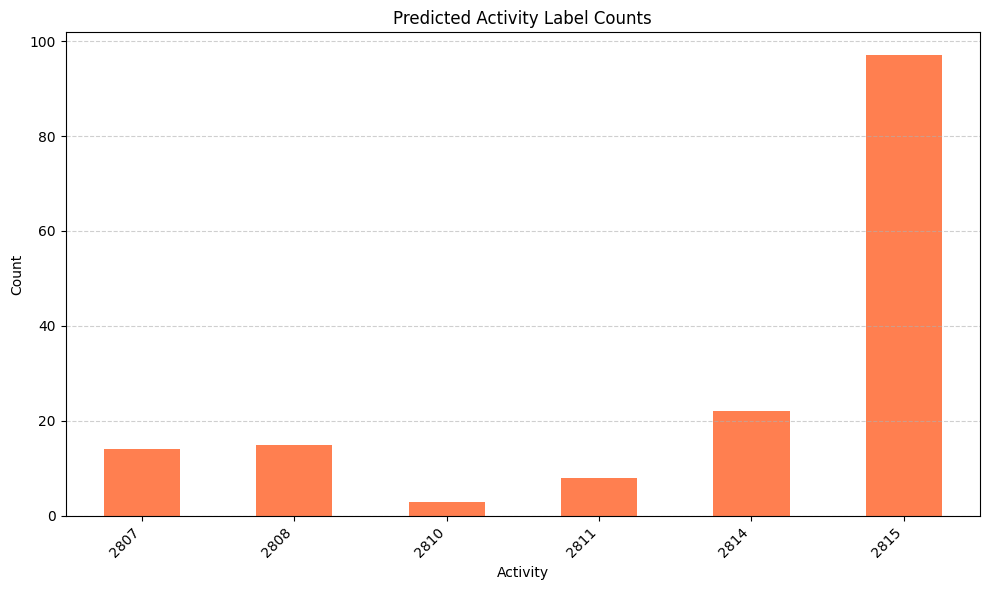

In [67]:
#load random forest model
rfc_saved_model = joblib.load('/Users/tptn/MachineLearning/tremor_challenge2/scripts/saved_models/random_forest_model_20250527_15.joblib')
# predict on test set
y_test_predict = rfc_saved_model.predict(test_features_df.values)

import matplotlib.pyplot as plt
import pandas as pd

predicted_labels = y_test_predict

# Count label occurrences
label_counts = pd.Series(predicted_labels).value_counts().sort_index(ascending=True)

# Plot
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='coral')
plt.title("Predicted Activity Label Counts")
plt.xlabel("Activity")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

label_map = {
    2806: '1 (FACING camera) Sit and stand',
    2807: '2 (FACING camera) both hands SHAKING (sitting position)',
    2808: '3 Stand up from chair - both hands with SHAKING',
    2809: '4 (Sideway) Sit & stand',
    2810: '5 (Sideway) both hands SHAKING (sitting)',
    2811: '6 (Sideway) STAND up with - both hands SHAKING',
    2812: '7 Cool down - sitting/relax',
    2813: '8 Walk (LEFT --> Right --> Left)',
    2814: '9 Walk & STOP/frozen, full body shaking, rotate then return back',
    2815: '10 Slow walk (SHAKING hands/body, tiny step, head forward)'
}

mapped_labels = [label_map[pred] for pred in y_test_predict]

result_df = pd.DataFrame({
    'ID': seg_id_list_test,
    'Output': mapped_labels
})

original_test_df = pd.read_csv('../data/TestingDataMay27/TestActivities-20240920.csv')
merged_df = pd.merge(original_test_df, result_df, on='ID', how='left')

# Step 4: Save to CSV
out_dir = os.makedirs('output', exist_ok=True)
out_file_path = os.path.join(out_dir, 'submission.csv')
merged_df.to_csv(out_file_path, index=False)